# Segmentación de cultivo y maleza en agricultura de precisión aplicando U-Net

Pontificia Universidad Católica del Perú

Escuela de Posgrado PUCP, Maestría en Informática, Ciencias de la Computacion

Curso: 
- Técnicas avanzadas de data mining y sistemas inteligentes

Alumnos:
- 20173589 Alarcon Flores, Jorge Brian
- 20173685 Chicchón Apaza, Miguel Angel
- 20173789 Alvarez Mouravskaia, Kevin
- 20173810 Pacheco Condori, Jesús Edwar

## Librerías

In [653]:
import numpy as np
import cv2 #https://opencv-python-tutroals.readthedocs.io/en/latest/index.html
import glob #https://docs.python.org/2/library/glob.html
from skimage.transform import rescale, resize #https://scikit-image.org/
from tqdm import tqdm_notebook as tqdm
import logging
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [289]:
from keras.models import Model, load_model, Sequential
from keras.layers import Input, UpSampling2D, ZeroPadding2D, Layer, Cropping2D, Add, Activation, Reshape, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

In [644]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [7]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Lectura de datos

In [575]:
def make_label(a):
    """
    Método que etiqueta los labels según colores
    Fuente: elaboración propia
    """    
    if a[1] == 255:
        a[0] = 255
        a[1] = 0
        a[2] = 0
    elif a[2] == 255:
        a[0] = 0
        a[1] = 255
        a[2] = 0
    else:
        a[0] = 0
        a[1] = 0
        a[2] = 255
    return (a / 255)

In [576]:
class DatasetProvider():
    """
    Clase que lee el dataset
    Fuente: elaboración propia
    """
    def __init__(self, scale=1.0/6.0):
        self.scale = scale
        self.x, self.y = self.__run__()
        
    def __run__(self):
        labels = self.__read_images__('annotation') 
        images = self.__read_images__('image') 
        x = self.__create_x__(images)
        y = self.__create_y_annotations__(labels)
        return x, y
        
    def __create_x__(self, images):
        logging.info('Creando imágenes')
        scale = self.scale
        height, width, channels = images[0].shape
        x = np.zeros((len(images), int(height * scale), int(width * scale), channels))
        for i, image in tqdm(enumerate(images)):
            image_rescaled = rescale(image, scale, anti_aliasing=True, multichannel=True, mode='reflect')
            x[i,:,:,:] = image_rescaled
        return x
    
    def __create_y_annotations__(self, annotations, shape=3):
        logging.info('Creando labels')
        scale = self.scale
        height, width, channels = annotations[0].shape
        labels = np.zeros((height, width, shape))
        y = np.zeros((len(annotations), int(height * scale), int(width * scale), shape))
        for i, image in tqdm(enumerate(annotations)):
            np_image = np.array(image)
            np_image = np.apply_along_axis(make_label, -1, np_image)
            image_rescaled = rescale(np_image, scale, anti_aliasing=True, multichannel=True, mode='reflect')
            y[i,:,:,:] = image_rescaled
        return y
        
    def __read_images__(self, prefix):
        logging.info('Leyendo imágenes {}'.format(prefix))
        images = []
        path = '../dataset/cwfid/' + prefix + 's'
        files = glob.glob(path + "/*.png")
        files = np.sort(files) 
        for i, img_name in enumerate(files):
            path_img = img_name.replace('\\','/')
            img = cv2.imread(path_img)
            images.append(img)
        return images

In [577]:
def execute_dataset_provider():
    dataset_provider = DatasetProvider()
    X = dataset_provider.x
    y = dataset_provider.y
    return X, y

In [671]:
X, y = execute_dataset_provider()

2018-11-05 21:23:06,621 Leyendo imágenes annotation
2018-11-05 21:23:07,336 Leyendo imágenes image
2018-11-05 21:23:09,459 Creando imágenes


2018-11-05 21:23:17,821 Creando labels


In [672]:
X.shape, y.shape

((60, 161, 216, 3), (60, 161, 216, 3))

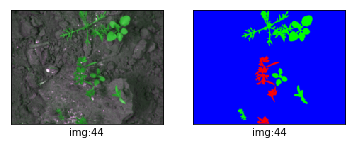

In [673]:
np.random.seed(0)
sample_idx = np.random.choice(len(X))  

plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.xlabel('img:{}'.format(sample_idx))
plt.imshow(X[sample_idx,:,:,:])

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.xlabel('img:{}'.format(sample_idx))
plt.imshow(y[sample_idx,:,:,:])

## Train validation split

In [674]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [675]:
X_train.shape, X_test.shape

((40, 161, 216, 3), (20, 161, 216, 3))

## Pre entrenamiento (Aumentación)

In [676]:
class DatasetAugmentation():
    
    def __init__(self, X, y):
        self.X, self.y = self.__run__(X, y)
        
    def __run__(self, X, y):
        logging.info('Realizando aumentación')
        X_augmentated = X
        y_augmentated = y
        for i, x_image in tqdm(enumerate(X)):
            fliplr_x_image = np.fliplr(x_image)
            flipup_x_image = np.flipud(x_image)
            fliplr_y_image = np.fliplr(y[i])
            flipup_y_image = np.flipud(y[i])
            X_augmentated = np.append(X_augmentated, [fliplr_x_image], axis=0)
            X_augmentated = np.append(X_augmentated, [flipup_x_image], axis=0)
            y_augmentated = np.append(y_augmentated, [fliplr_y_image], axis=0)
            y_augmentated = np.append(y_augmentated, [flipup_y_image], axis=0)
        return X_augmentated, y_augmentated

In [677]:
def execute_dataset_pretrain(X, y):
    dataset = DatasetAugmentation(X, y)
    X_augmentated =  dataset.X
    y_augmentated = dataset.y
    return X_augmentated, y_augmentated

In [678]:
X_train, y_train = execute_dataset_pretrain(X_train, y_train)
X_test, y_test = execute_dataset_pretrain(X_test, y_test)

2018-11-05 21:35:10,494 Realizando aumentación


2018-11-05 21:35:18,634 Realizando aumentación


In [679]:
X_train.shape, X_test.shape

((120, 161, 216, 3), (60, 161, 216, 3))

## Pre entrenamiento (normalización)

In [469]:
## TODO validar si es necesario

## Métricas

In [470]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [319]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Modelo U-Net

### Definir modelo

![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [603]:
class ModelUnetCreator():
    
    #Fuente: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
    def unet(self, height, width, channels):
        
        start_neurons = 16
        n_classes = 3
        
        #input
        inputs = Input((height, width, channels))
        zero_padding = ZeroPadding2D(padding=((7,8),(4,4))) (inputs)
        
        #downscaling
        c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (zero_padding)
        c1 = Dropout(0.1) (c1)
        c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)
        
        c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
        c2 = Dropout(0.1) (c2)
        c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
        c3 = Dropout(0.2) (c3)
        c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
        c4 = Dropout(0.2) (c4)
        c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
        
        #capa intermedia 
        c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
        c5 = Dropout(0.3) (c5)
        c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)
        
        #upscaling
        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
        c6 = Dropout(0.2) (c6)
        c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
        c7 = Dropout(0.2) (c7)
        c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
        c8 = Dropout(0.1) (c8)
        c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
        c9 = Dropout(0.1) (c9)
        c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)
        
        #output
        output = Conv2D(n_classes, (1,1), padding="same", activation=None)(c9)
        output = Cropping2D(cropping=((7,8),(4,4))) (output)
        output_layer = (Reshape((height, width, 3),
                          input_shape=(height, width, 3)))(output)
        output_layer =  Activation('sigmoid')(output_layer)
        
        model = Model(inputs=[inputs], outputs=[output_layer])
        
        return model    

In [604]:
def execute_model_unet():
    logging.info('Creando modelo U-Net')
    model = ModelUnetCreator()
    model_unet = model.unet(X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model_unet.compile(loss = 'binary_crossentropy',
             optimizer = 'Adam',
             metrics = [f1, mean_iou])
    model_unet.summary()
    return model_unet

In [605]:
model_unet = execute_model_unet()

2018-11-05 19:54:07,161 Creando modelo U-Net


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 161, 216, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_73 (ZeroPadding2 (None, 176, 224, 3)  0           input_47[0][0]                   
__________________________________________________________________________________________________
conv2d_878 (Conv2D)             (None, 176, 224, 16) 448         zero_padding2d_73[0][0]          
__________________________________________________________________________________________________
dropout_379 (Dropout)           (None, 176, 224, 16) 0           conv2d_878[0][0]                 
__________________________________________________________________________________________________
conv2d_879

### Entrenamiento

In [607]:
callbacks_full = [
    ModelCheckpoint('model-unet-cwfid.h5', verbose=1, save_best_only=True)
]

model_unet_full_history = model_unet.fit(x = X_train,
                         y = y_train,
                         batch_size = 32,
                         epochs = 30,
                         verbose = 1,
                         validation_split = 0.2,
                          callbacks = callbacks_full
                         )

Train on 96 samples, validate on 24 samples
Epoch 1/30
96/96 [==============================] - 9s 90ms/step - loss: 0.6895 - f1: 0.5149 - mean_iou: 0.2304 - val_loss: 0.6610 - val_f1: 0.6343 - val_mean_iou: 0.3544

Epoch 00001: val_loss improved from inf to 0.66100, saving model to model-unet-cwfid.h5
Epoch 2/30
96/96 [==============================] - 2s 19ms/step - loss: 0.6221 - f1: 0.7089 - mean_iou: 0.3634 - val_loss: 0.4496 - val_f1: 0.8044 - val_mean_iou: 0.3877

Epoch 00002: val_loss improved from 0.66100 to 0.44959, saving model to model-unet-cwfid.h5
Epoch 3/30
96/96 [==============================] - 2s 18ms/step - loss: 0.4340 - f1: 0.8281 - mean_iou: 0.4503 - val_loss: 0.3414 - val_f1: 0.9292 - val_mean_iou: 0.5250

Epoch 00003: val_loss improved from 0.44959 to 0.34144, saving model to model-unet-cwfid.h5
Epoch 4/30
96/96 [==============================] - 2s 18ms/step - loss: 0.3107 - f1: 0.9227 - mean_iou: 0.5597 - val_loss: 0.2811 - val_f1: 0.9308 - val_mean_iou: 0.59

### Métricas

In [ ]:
model_unet.evaluate(X_val, y_val)

## Modelo Seg-Net

### Definir modelo

In [609]:
#Fuente: https://github.com/Anki0909/CWFID-Image-Segmentation/blob/master/main.py
def segnet(n_classes, input_height=161, input_width=216):
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    
    model = Sequential()
    model.add(Layer(input_shape=(input_height, input_width, 3)))
    model.add(ZeroPadding2D(padding=((7,8),(0,0))))
    
    model.add(Conv2D(filter_size,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size)))
    
    model.add(Conv2D(128,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size)))
    
    model.add(Conv2D(256,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size,pool_size)))
    
    model.add(Conv2D(512,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(512,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    
    model.add(UpSampling2D(size=(pool_size,pool_size)))
    model.add(Conv2D(256,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    
    model.add(UpSampling2D(size=(pool_size,pool_size)))
    model.add(Conv2D(128,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    
    model.add(UpSampling2D(size=(pool_size,pool_size)))
    model.add(Conv2D(filter_size,(kernel,kernel),padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(n_classes,(1,1), padding='same'))
    
    model.add(Cropping2D(cropping=((7,8),(0,0))))
    
    model.outputHeight = model.output_shape[-3]
    model.outputWidth = model.output_shape[-2]
    
    if n_classes == 1:
        model.add(Reshape((model.output_shape[-3], model.output_shape[-2]),
                          input_shape=(model.output_shape[-3], model.output_shape[-2], 3)))
        model.add(Activation('sigmoid'))
    else:
        model.add(Reshape((model.output_shape[-3], model.output_shape[-2], n_classes),
                          input_shape=(model.output_shape[-3], model.output_shape[-2], 3)))
        model.add(Activation('sigmoid'))
        
    #if not optimizer is None:
    #    model.compile(loss="categorical_crossentropy", optimizer= optimizer , metrics=['accuracy'] )
        
    return model

In [610]:
model_segnet = segnet(n_classes=3)
model_segnet.compile(loss = 'binary_crossentropy',
             optimizer = 'Adam',
             metrics = [f1, mean_iou])

In [611]:
model_segnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_39 (Layer)             (None, 161, 216, 3)       0         
_________________________________________________________________
zero_padding2d_74 (ZeroPaddi (None, 176, 216, 3)       0         
_________________________________________________________________
conv2d_897 (Conv2D)          (None, 176, 216, 64)      1792      
_________________________________________________________________
batch_normalization_183 (Bat (None, 176, 216, 64)      256       
_________________________________________________________________
activation_463 (Activation)  (None, 176, 216, 64)      0         
_________________________________________________________________
max_pooling2d_261 (MaxPoolin (None, 88, 108, 64)       0         
_________________________________________________________________
conv2d_898 (Conv2D)          (None, 88, 108, 128)      73856     
__________

### Entrenamiento

In [612]:
callbacks_full = [
    ModelCheckpoint('model-segnet-cwfid.h5', verbose=1, save_best_only=True)
]

model_segnet_full_history = model_segnet.fit(x = X_train,
                         y = y_train,
                         batch_size = 32,
                         epochs = 30,
                         verbose = 1,
                         validation_split = 0.2,
                          callbacks = callbacks_full
                         )

Train on 96 samples, validate on 24 samples
Epoch 1/30
96/96 [==============================] - 42s 436ms/step - loss: 0.9127 - f1: 0.4910 - mean_iou: 0.2641 - val_loss: 3.3892 - val_f1: 0.6446 - val_mean_iou: 0.4228

Epoch 00001: val_loss improved from inf to 3.38915, saving model to model-segnet-cwfid.h5
Epoch 2/30
96/96 [==============================] - 4s 39ms/step - loss: 0.5899 - f1: 0.6753 - mean_iou: 0.4422 - val_loss: 0.4690 - val_f1: 0.8510 - val_mean_iou: 0.4535

Epoch 00002: val_loss improved from 3.38915 to 0.46900, saving model to model-segnet-cwfid.h5
Epoch 3/30
96/96 [==============================] - 4s 38ms/step - loss: 0.4788 - f1: 0.8296 - mean_iou: 0.4844 - val_loss: 0.7188 - val_f1: 0.7325 - val_mean_iou: 0.5018

Epoch 00003: val_loss did not improve from 0.46900
Epoch 4/30
96/96 [==============================] - 4s 38ms/step - loss: 0.3883 - f1: 0.8586 - mean_iou: 0.5198 - val_loss: 1.1592 - val_f1: 0.5956 - val_mean_iou: 0.5381

Epoch 00004: val_loss did not i

### Métricas

In [614]:
pred_model_segnet = model_segnet.predict(X_test)

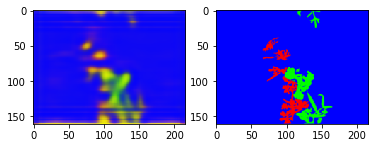

In [618]:
i = 5
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pred_model_segnet[i,:,:,:])
plt.subplot(1,2,2)
plt.imshow(y_test[i,:,:,:])

## Modelo U-Net Res

### Definir modelo

In [628]:
#Fuente: https://github.com/Anki0909/CWFID-Image-Segmentation/blob/master/main.py
def unet_res(n_classes = 1, start_neurons = 16, DropoutRatio = 0.5, img_height=161,img_width=216):
    
    def BatchActivate(x):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
        x = Conv2D(filters, size, strides=strides, padding=padding)(x)
        if activation == True:
            x = BatchActivate(x)
        return x

    def residual_block(blockInput, num_filters=16, batch_activate = False):
        x = BatchActivate(blockInput)
        x = convolution_block(x, num_filters, (3,3) )
        x = convolution_block(x, num_filters, (3,3), activation=False)
        x = Add()([x, blockInput])
        if batch_activate:
            x = BatchActivate(x)
        return x

    # 101 -> 50
    input_layer = Input((img_height, img_width, 3))
    zero_pad = ZeroPadding2D(padding=((7,8),(4,4)))(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(zero_pad)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(n_classes, (1,1), padding="same", activation=None)(uconv1)
    output_layer = Cropping2D(cropping=((7,8),(4,4)))(output_layer_noActi)
    
    if n_classes == 1:
        output_layer = (Reshape((img_height, img_width),
                          input_shape=(img_height, img_width, 3)))(output_layer)
    else:
        output_layer = (Reshape((img_height, img_width, n_classes),
                          input_shape=(img_height, img_width, 3)))(output_layer)
    
    output_layer =  Activation('sigmoid')(output_layer)
    
    model = Model(input_layer, output_layer)
    
    return model

In [636]:
model_unet_res = unet_res(n_classes=3)
model_unet_res.compile(loss = 'binary_crossentropy',
             optimizer = 'Adam',
             metrics = [f1, mean_iou])

In [643]:
model_unet_res.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 161, 216, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_76 (ZeroPadding2 (None, 176, 224, 3)  0           input_49[0][0]                   
__________________________________________________________________________________________________
conv2d_952 (Conv2D)             (None, 176, 224, 16) 448         zero_padding2d_76[0][0]          
__________________________________________________________________________________________________
batch_normalization_236 (BatchN (None, 176, 224, 16) 64          conv2d_952[0][0]                 
__________________________________________________________________________________________________
activation

### Entrenamiento

In [638]:
callbacks_full = [
    ModelCheckpoint('model-unet-res-cwfid.h5', verbose=1, save_best_only=True)
]

model_unet_res_full_history = model_unet_res.fit(x = X_train,
                         y = y_train,
                         batch_size = 32,
                         epochs = 30,
                         verbose = 1,
                         validation_split = 0.2,
                          callbacks = callbacks_full
                         )

Train on 96 samples, validate on 24 samples
Epoch 1/30
96/96 [==============================] - 48s 504ms/step - loss: 0.8455 - f1: 0.1665 - mean_iou: 0.2063 - val_loss: 1.1605 - val_f1: 0.0827 - val_mean_iou: 0.3122

Epoch 00001: val_loss improved from inf to 1.16051, saving model to model-unet-res-cwfid.h5
Epoch 2/30
96/96 [==============================] - 4s 44ms/step - loss: 0.7290 - f1: 0.3156 - mean_iou: 0.3153 - val_loss: 4.7468 - val_f1: 0.1779 - val_mean_iou: 0.3215

Epoch 00002: val_loss did not improve from 1.16051
Epoch 3/30
96/96 [==============================] - 4s 43ms/step - loss: 0.6542 - f1: 0.4889 - mean_iou: 0.3171 - val_loss: 3.2418 - val_f1: 0.3031 - val_mean_iou: 0.3264

Epoch 00003: val_loss did not improve from 1.16051
Epoch 4/30
96/96 [==============================] - 4s 43ms/step - loss: 0.6052 - f1: 0.6271 - mean_iou: 0.3273 - val_loss: 0.9712 - val_f1: 0.4738 - val_mean_iou: 0.3353

Epoch 00004: val_loss improved from 1.16051 to 0.97119, saving model to 

### k-Fold
Puede demorar mucho tiempo

In [690]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1337)

In [698]:
def k_fold(X_train, y_train):
    
    histories = []
    for train, test in kfold.split(X_train, y_train):
        _X_train = X_train[train]
        x_val = X_train[test]
        _y_train = y_train[train]
        y_val = y_train[test]

        # Fit the model for each split
        callbacks_full = [
            ModelCheckpoint('model-unet-res-cwfid.h5', verbose=1, save_best_only=True)
        ]

        model_unet_res_full_history = model_unet_res.fit(x = _X_train,
                                 y = _y_train,
                                 batch_size = 32,
                                 epochs = 10,
                                 verbose = 1,
                                 validation_data=([x_val], y_val),callbacks = callbacks_full)

        histories.append(model_unet_res_full_history)

        # Evaluation after each split
        scores = model_unet_res.evaluate(x_val, y_val)
        print('Scores: {}'.format(scores))

In [699]:
k_fold(X_train, y_train)

Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 4s 44ms/step - loss: 0.1984 - f1: 0.9519 - mean_iou: 0.5609 - val_loss: 0.2008 - val_f1: 0.9516 - val_mean_iou: 0.5624

Epoch 00001: val_loss improved from inf to 0.20076, saving model to model-unet-res-cwfid.h5
Epoch 2/10
96/96 [==============================] - 4s 43ms/step - loss: 0.1943 - f1: 0.9528 - mean_iou: 0.5637 - val_loss: 0.2045 - val_f1: 0.9363 - val_mean_iou: 0.5652

Epoch 00002: val_loss did not improve from 0.20076
Epoch 3/10
96/96 [==============================] - 4s 43ms/step - loss: 0.1903 - f1: 0.9537 - mean_iou: 0.5665 - val_loss: 0.1965 - val_f1: 0.9519 - val_mean_iou: 0.5679

Epoch 00003: val_loss improved from 0.20076 to 0.19652, saving model to model-unet-res-cwfid.h5
Epoch 4/10
96/96 [==============================] - 4s 43ms/step - loss: 0.1869 - f1: 0.9542 - mean_iou: 0.5692 - val_loss: 0.1974 - val_f1: 0.9398 - val_mean_iou: 0.5707

Epoch 00004: val_loss did not

96/96 [==============================] - 4s 43ms/step - loss: 0.1083 - f1: 0.9661 - mean_iou: 0.6439 - val_loss: 0.1311 - val_f1: 0.9465 - val_mean_iou: 0.6451

Epoch 00002: val_loss did not improve from 0.12566
Epoch 3/10
96/96 [==============================] - 4s 43ms/step - loss: 0.1087 - f1: 0.9643 - mean_iou: 0.6461 - val_loss: 0.1389 - val_f1: 0.9385 - val_mean_iou: 0.6474

Epoch 00003: val_loss did not improve from 0.12566
Epoch 4/10
96/96 [==============================] - 4s 43ms/step - loss: 0.1053 - f1: 0.9658 - mean_iou: 0.6484 - val_loss: 0.1344 - val_f1: 0.9427 - val_mean_iou: 0.6495

Epoch 00004: val_loss did not improve from 0.12566
Epoch 5/10
96/96 [==============================] - 4s 43ms/step - loss: 0.1032 - f1: 0.9670 - mean_iou: 0.6505 - val_loss: 0.1271 - val_f1: 0.9493 - val_mean_iou: 0.6517

Epoch 00005: val_loss did not improve from 0.12566
Epoch 6/10
96/96 [==============================] - 4s 43ms/step - loss: 0.1015 - f1: 0.9666 - mean_iou: 0.6527 - val_l

### Métricas

In [639]:
pred_model_unet_res = model_unet_res.predict(X_test)

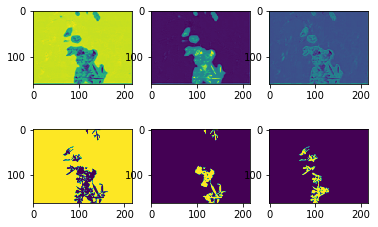

In [640]:
i = 5
plt.figure()
plt.subplot(2,3,1)
plt.imshow(pred_model_unet_res[i,:,:,2])
plt.subplot(2,3,4)
plt.imshow(y_test[i,:,:,2])
plt.subplot(2,3,2)
plt.imshow(pred_model_unet_res[i,:,:,1])
plt.subplot(2,3,5)
plt.imshow(y_test[i,:,:,1])
plt.subplot(2,3,3)
plt.imshow(pred_model_unet_res[i,:,:,0])
plt.subplot(2,3,6)
plt.imshow(y_test[i,:,:,0])

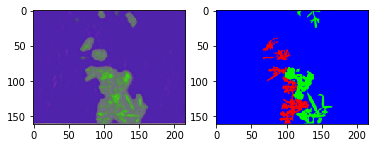

In [641]:
i = 5
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pred_model_unet_res[i,:,:,:])
plt.subplot(1,2,2)
plt.imshow(y_test[i,:,:,:])